In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import shap
import gower

In [2]:
df = pd.read_csv('data/ilpd-clustered.csv')

In [3]:
df

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,...,Clusters_KProto_k5,Clusters_GMM_k2,Clusters_GMM_k4,Clusters_GMM_k7,Clusters_HDBScan_MinClusters5,Clusters_HDBScan_MinClusters6,Clusters_Spectral_k2,Clusters_Spectral_k4,Clusters_Spectral_k6,Label
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,...,0,0,0,0,1,0,1,1,0,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,...,3,0,1,1,-1,-1,0,2,2,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,...,0,0,1,1,-1,0,0,3,3,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,...,0,0,0,0,1,0,0,3,3,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,...,0,0,0,1,1,0,0,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,...,0,0,1,1,1,0,0,3,5,2
575,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,...,0,0,0,0,1,0,0,0,4,1
576,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,...,0,0,0,0,1,0,0,3,3,1
577,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,...,0,0,0,0,1,0,0,0,1,1


In [4]:
df.columns

Index(['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB',
       'A/G Ratio', 'Clusters_KProto_k2', 'Clusters_KProto_k4',
       'Clusters_KProto_k5', 'Clusters_GMM_k2', 'Clusters_GMM_k4',
       'Clusters_GMM_k7', 'Clusters_HDBScan_MinClusters5',
       'Clusters_HDBScan_MinClusters6', 'Clusters_Spectral_k2',
       'Clusters_Spectral_k4', 'Clusters_Spectral_k6', 'Label'],
      dtype='object')

In [5]:
# Features (drop cluster columns and label)
X_features = df.drop(columns=[col for col in df.columns if col.startswith("Clusters_")]+['Label'])

# Cluster labels as target
y_target = df['Clusters_Spectral_k6']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
)

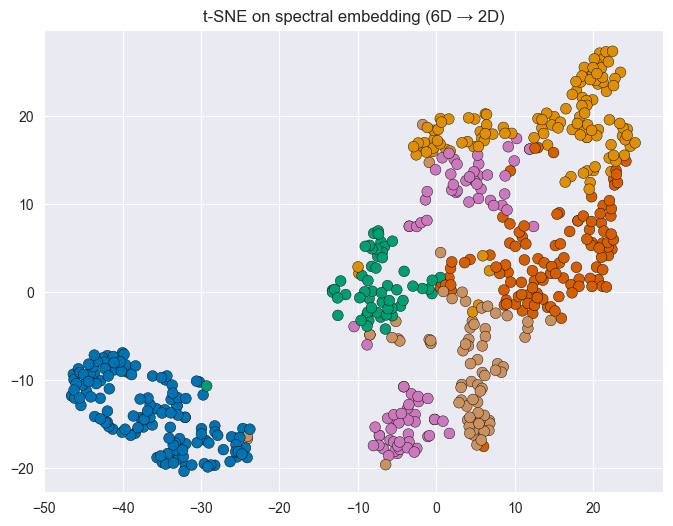

In [7]:
# compute similarity as you already do
gower_dist = gower.gower_matrix(X_features)
similarity = 1 - gower_dist

# spectral embedding with more components (keep some extra info)
spec = SpectralEmbedding(n_components=6, affinity='precomputed', random_state=42)
emb6 = spec.fit_transform(similarity)

# optional: row-normalize (common for normalized Laplacian / spectral clustering)
emb6_norm = normalize(emb6, norm='l2', axis=1)

n_clusters = len(np.unique(y_target))
colors = sns.color_palette("colorblind", n_colors=n_clusters)

# emb6 or emb6_norm from above
tsne = TSNE(n_components=2, init='pca', perplexity=30, random_state=42)
emb2_tsne = tsne.fit_transform(emb6_norm)

plt.figure(figsize=(8,6))
plt.scatter(emb2_tsne[:,0], emb2_tsne[:,1], c=y_target,
            cmap=mcolors.ListedColormap(colors), s=60, edgecolor='k', linewidth=0.3)
plt.title("t-SNE on spectral embedding (6D → 2D)")
plt.show()

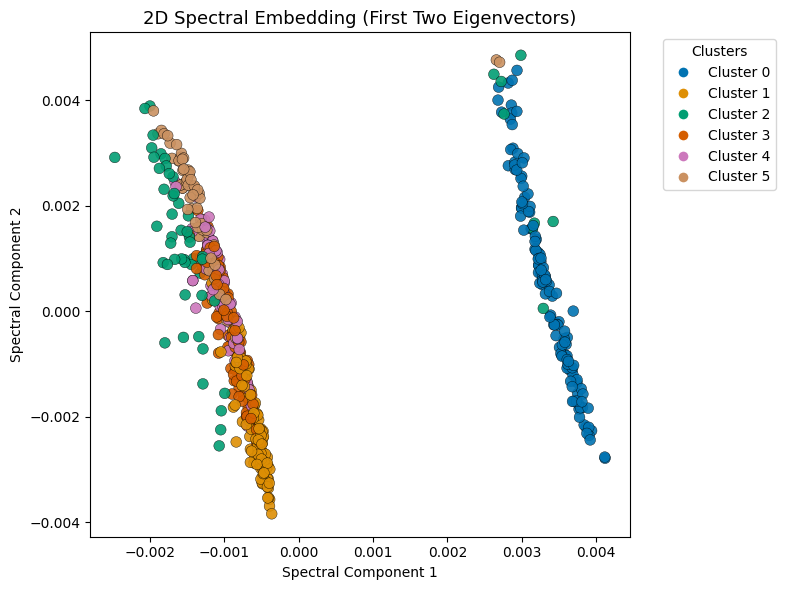

In [145]:
gower_dist = gower.gower_matrix(X_features)
similarity = 1 - gower_dist  # affinity matrix

# --- Compute 2D Spectral Embedding ---
embedding_2d = SpectralEmbedding(
    n_components=2,
    affinity='precomputed',
    random_state=42
).fit_transform(similarity)

# --- Prepare colors for clusters ---
n_clusters = len(np.unique(y_target))
colors = sns.color_palette("colorblind", n_colors=n_clusters)

# --- Plot 2D spectral embedding ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=y_target,
    cmap=mcolors.ListedColormap(colors),
    s=60, alpha=0.9, edgecolor='k', linewidth=0.3
)

# --- Legend ---
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {c}',
               markerfacecolor=colors[i], markersize=8)
    for i, c in enumerate(sorted(np.unique(y_target)))
]
plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Aesthetics ---
plt.title("2D Spectral Embedding (First Two Eigenvectors)", fontsize=13)
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.tight_layout()
plt.show()

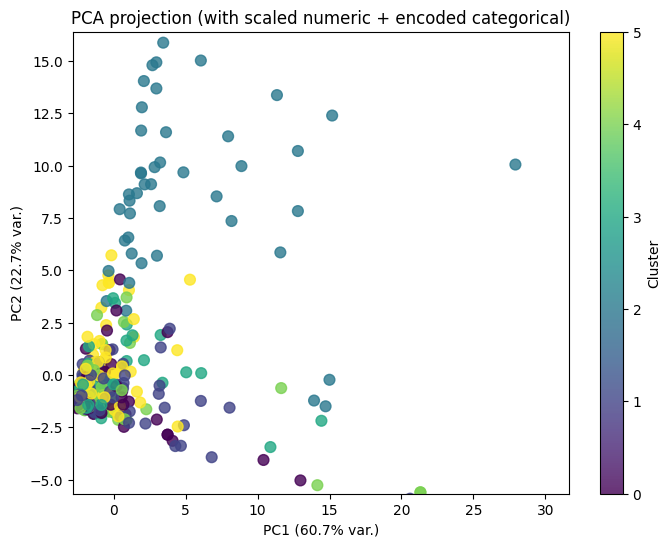

In [141]:
# Identify column types
num_cols = X_features.select_dtypes(include=['number']).columns
cat_cols = X_features.select_dtypes(exclude=['number']).columns

# Preprocessing pipeline: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

# Apply transformation
X_preprocessed = preprocessor.fit_transform(X_features)

# Dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)


# Plot clusters
plt.figure(figsize=(8, 6))

# xlims = np.percentile(X_pca[:, 0], [1, 99])
# ylims = np.percentile(X_pca[:, 1], [1, 99])
# plt.xlim(xlims)
# plt.ylim(ylims)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_target, cmap='viridis', s=60, alpha=0.8)
plt.title("PCA projection (with scaled numeric + encoded categorical)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [91]:
# Encode categorical columns
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for col in X_train.select_dtypes(include=['object', 'category']):
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train[col])
    X_test_enc[col] = le.transform(X_test[col])

# Train Random Forest
rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf.fit(X_train_enc, y_train)

,n_estimators,5
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [92]:
y_pred = rf.predict(X_test_enc)

# --- Basic metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")

# --- Detailed class-by-class report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- Optional: Confusion matrix ---
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Accuracy : 0.940
Precision: 0.940
Recall   : 0.940
F1-score : 0.940

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.96      0.96      0.96        24
           2       1.00      0.91      0.95        11
           3       0.87      0.87      0.87        23
           4       0.88      0.88      0.88        17
           5       0.94      1.00      0.97        15

    accuracy                           0.94       116
   macro avg       0.94      0.94      0.94       116
weighted avg       0.94      0.94      0.94       116

Confusion Matrix:


array([[26,  0,  0,  0,  0,  0],
       [ 0, 23,  0,  1,  0,  0],
       [ 0,  0, 10,  0,  0,  1],
       [ 0,  1,  0, 20,  2,  0],
       [ 0,  0,  0,  2, 15,  0],
       [ 0,  0,  0,  0,  0, 15]])

In [93]:
rf.score(X_train_enc, y_train), rf.score(X_test_enc, y_test)

(0.978401727861771, 0.9396551724137931)

In [94]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_enc.columns)
feat_importances = feat_importances.sort_values(ascending=False)
print(feat_importances)

Gender       0.249747
Age          0.184653
TP           0.162150
TB           0.107825
ALB          0.096548
DB           0.063107
A/G Ratio    0.042800
Alkphos      0.038561
Sgot         0.033627
Sgpt         0.020984
dtype: float64


In [95]:
perm_importance = permutation_importance(rf, X_test_enc, y_test, n_repeats=10, random_state=42)
perm_df = pd.Series(perm_importance.importances_mean, index=X_train_enc.columns).sort_values(ascending=False)
print(perm_df)

Gender       0.329310
Age          0.203448
TP           0.190517
ALB          0.132759
TB           0.070690
DB           0.019828
A/G Ratio    0.018103
Alkphos      0.016379
Sgpt         0.008621
Sgot        -0.009483
dtype: float64


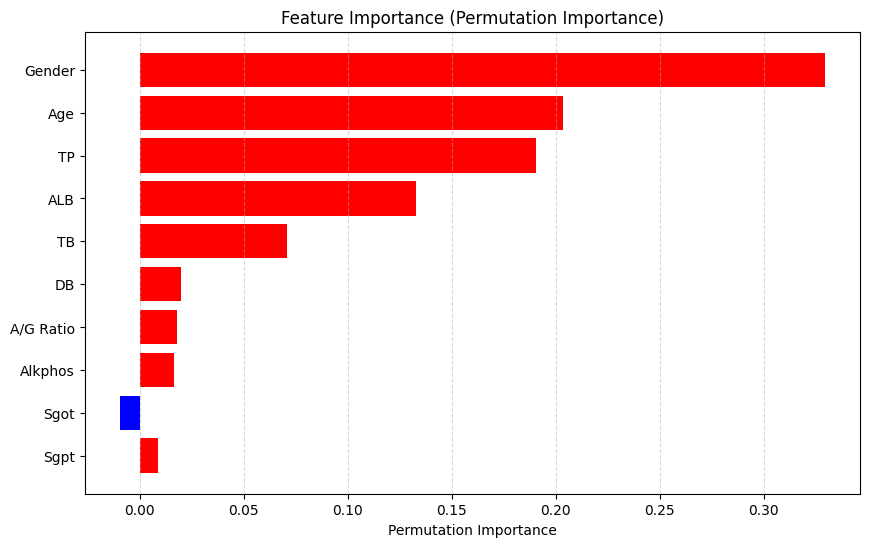

In [96]:
# Sort the features by importance
perm_df_sorted = perm_df.reindex(perm_df.abs().sort_values(ascending=True).index)

# Set colors: red for positive, blue for negative
colors = ['red' if v > 0 else 'blue' for v in perm_df_sorted.values]

# Create horizontal bar plot
plt.figure(figsize=(10,6))
plt.barh(perm_df_sorted.index, perm_df_sorted.values, color=colors)
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation Importance)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

[[[-1.49141612e-03 -5.92903236e-02 -4.43599031e-03  7.38536058e-02
   -3.20022320e-02  2.33663563e-02]
  [ 7.14829503e-01 -2.06469123e-01 -7.52390635e-03 -3.82114181e-01
   -5.79006991e-02 -6.08215932e-02]
  [ 2.23311737e-02  2.55736972e-03 -3.73115736e-02  5.38351975e-03
    4.45739284e-03  2.58211761e-03]
  ...
  [ 5.06875478e-03  2.37716775e-02 -1.52462560e-03  2.23032524e-02
   -4.69470854e-02 -2.67197362e-03]
  [ 1.01490096e-02  3.52421221e-02 -4.71035052e-03  3.54219319e-02
   -2.38190121e-02 -5.22837009e-02]
  [ 2.97034575e-03 -8.60270682e-04 -6.00301773e-04  1.79424845e-02
    1.39602925e-03 -2.08482870e-02]]

 [[-1.87094312e-03 -9.52106506e-02 -7.88507464e-03  6.62654438e-02
   -1.14053098e-01  1.52754322e-01]
  [-1.74779056e-01  2.53128505e-02  6.20005881e-03  3.13600203e-02
    2.81638616e-02  8.37422651e-02]
  [-3.32437860e-03 -9.84725324e-03 -5.41576664e-02  1.70683248e-04
   -2.32099288e-02  9.03685438e-02]
  ...
  [ 2.97786028e-03 -9.52387321e-02 -1.47075483e-02 -3.39707

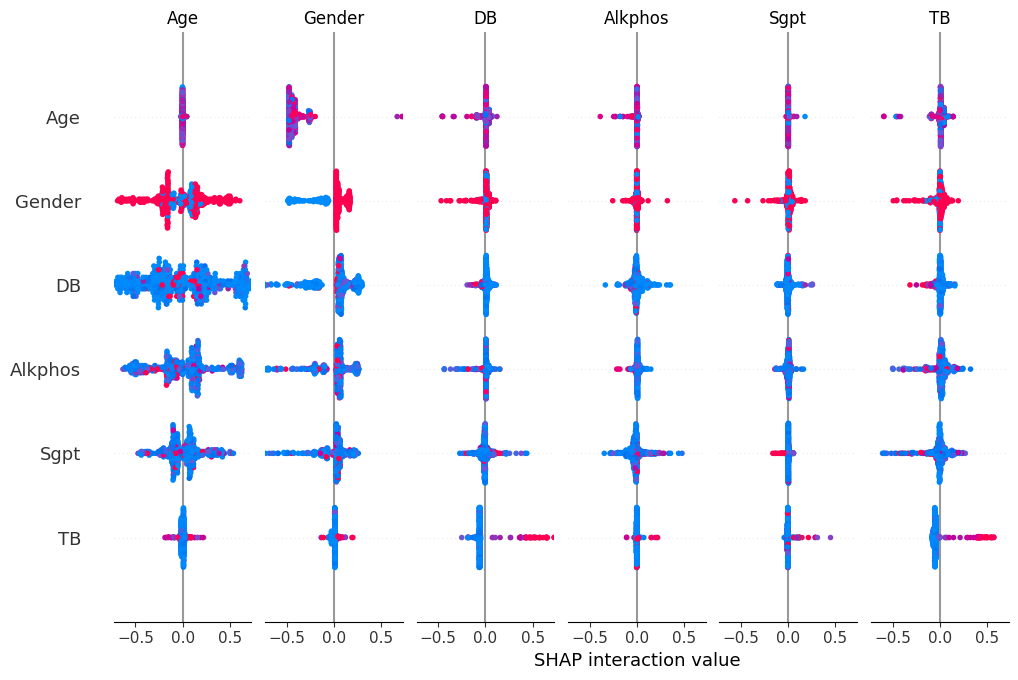

In [97]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_enc)

print(shap_values)
# Summary plot for cluster 0 vs rest
shap.summary_plot(shap_values, X_train_enc)

# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

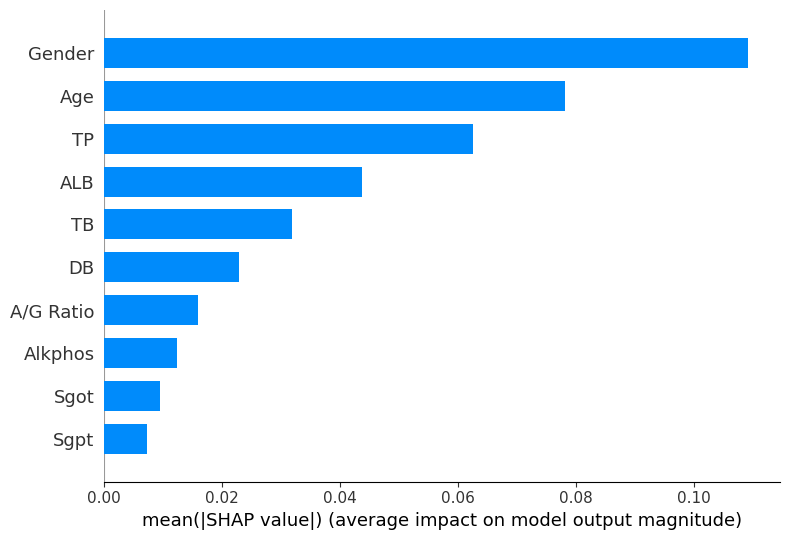

In [98]:
# Convert list of arrays (one per class) into a single 3D array
shap_values_array = np.stack(shap_values)  # shape: (n_classes, n_samples, n_features)

# Compute mean absolute SHAP value across classes
shap_values_combined = np.mean(np.abs(shap_values_array), axis=2)  # shape: (n_samples, n_features)

# Now plot a single summary (bar) plot
shap.summary_plot(shap_values_combined, X_train_enc, plot_type="bar")

In [99]:
print(shap_values_array.shape)
print(X_train_enc.shape)


(463, 10, 6)
(463, 10)


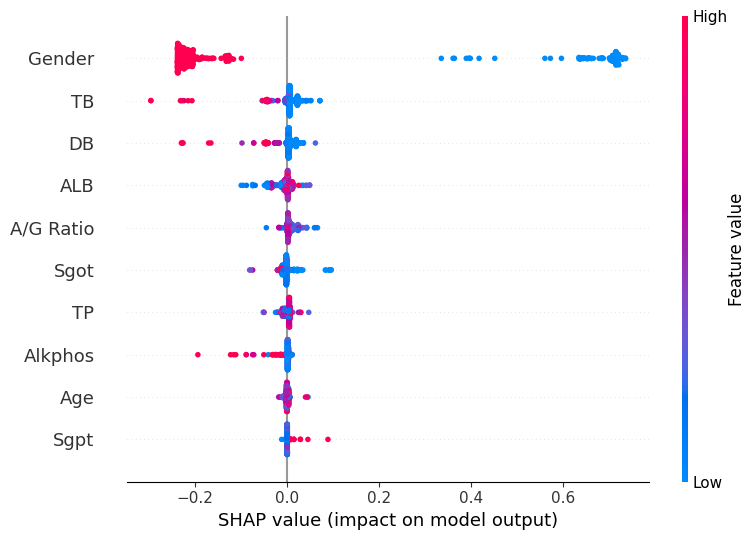

In [102]:
shap.summary_plot(shap_values[:, :, 0], X_train_enc) # Just for cluster 0!!!!

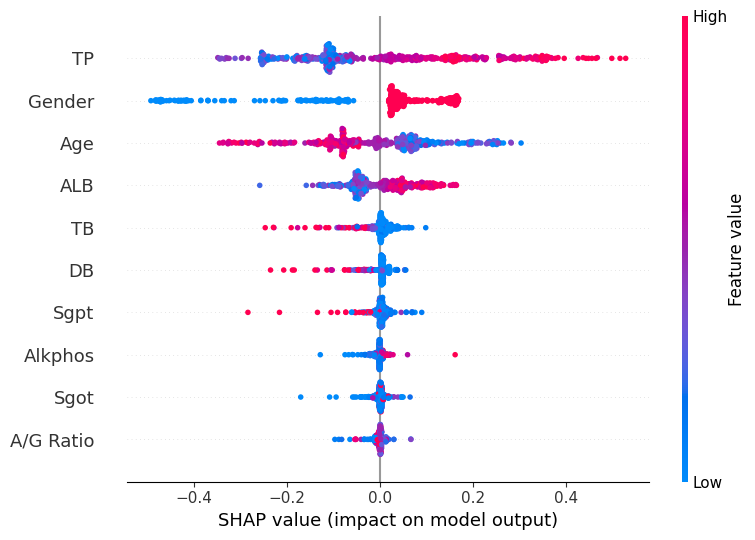

In [101]:
shap.summary_plot(shap_values[:, :, 1], X_train_enc) # Just for cluster 1!!!!

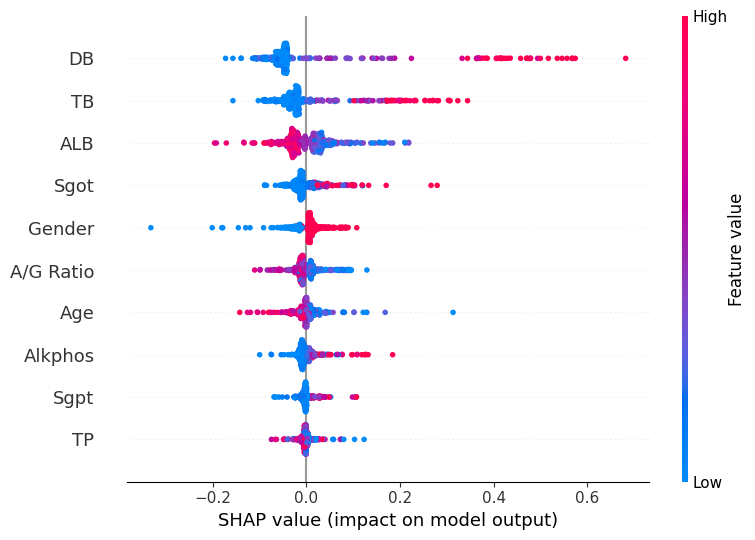

In [72]:
shap.summary_plot(shap_values[:, :, 2], X_train_enc) # Just for cluster 2!!!!

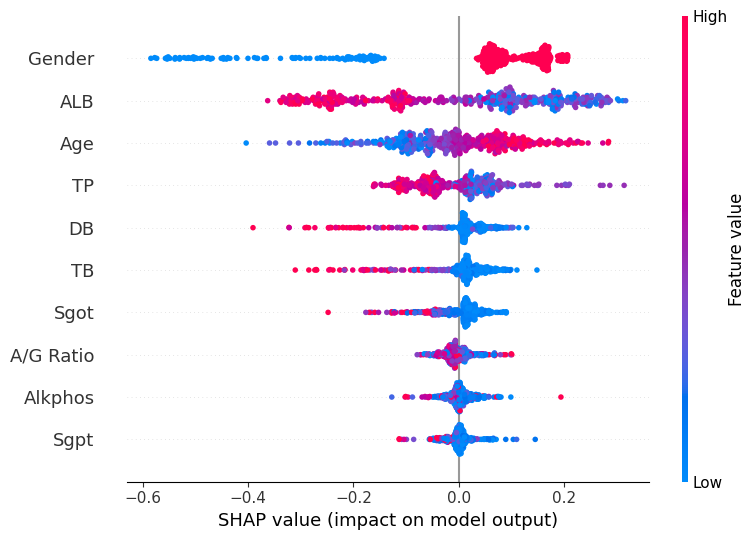

In [73]:
shap.summary_plot(shap_values[:, :, 3], X_train_enc) # Just for cluster 3!!!!